In [ ]:
%pip install haversine

import pandas as pd
import numpy as np          
import matplotlib.pyplot as plt
import seaborn as sns   
from haversine import haversine, Unit
import itertools

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv('root_level.csv')
station_df = pd.read_csv('unique_station_data.csv', parse_dates=['datetime_start', 'datetime_end'])

In [3]:
df.shape

(131800, 29)

In [4]:
df.head()

,bicycle_id,start_time,start_location,end_location,duration,route,index,temperature_C,humidity,windspeed_kph,...,temperature_bin,wind_chill_bin,humidity_bin,hour,time_of_day,month,month_str,bad_weather,severe_weather,date
0,86602,2015-01-01 00:04:00,802,508,0 days 00:06:00,802-508,0,-12.0,85,5.6,...,Very Cold,Very Cold,High,0,LateNight,1,Jan,0,0,2015-01-01
1,86157,2015-01-01 00:04:00,802,508,0 days 00:12:00,802-508,0,-12.0,85,5.6,...,Very Cold,Very Cold,High,0,LateNight,1,Jan,0,0,2015-01-01
2,86091,2015-01-01 00:08:00,513,1106,0 days 00:24:00,513-1106,0,-12.0,85,5.6,...,Very Cold,Very Cold,High,0,LateNight,1,Jan,0,0,2015-01-01
3,86908,2015-01-01 00:09:00,513,604,0 days 00:20:00,513-604,0,-12.0,85,5.6,...,Very Cold,Very Cold,High,0,LateNight,1,Jan,0,0,2015-01-01
4,86075,2015-01-01 00:15:00,516,901,0 days 00:06:00,516-901,0,-12.0,85,5.6,...,Very Cold,Very Cold,High,0,LateNight,1,Jan,0,0,2015-01-01


Ranking all rental points by their average daily trip counts.

In [5]:

# Group by starting station and date, counting trips
start_counts = df.groupby(['start_location', 'date']).size().reset_index(name='trip_count')
start_counts = start_counts.rename(columns={'start_location': 'station'})

# Group by ending station and date, counting trips
end_counts = df.groupby(['end_location', 'date']).size().reset_index(name='trip_count')
end_counts = end_counts.rename(columns={'end_location': 'station'})

# Combine both start and end counts
combined = pd.concat([start_counts, end_counts], ignore_index=True)

# Aggregate to get the total trips per station per day
daily_station = combined.groupby(['station', 'date']).agg(total_trips=('trip_count', 'sum')).reset_index()

# Compute the average daily trips for each station
average_daily = daily_station.groupby('station').agg(avg_daily_trips=('total_trips', 'mean')).reset_index()

# Sort the result by highest average daily trip counts
average_daily = average_daily.sort_values('avg_daily_trips', ascending=False)

In [6]:
average_daily.head(10
                  )

,station,avg_daily_trips
72,1304,63.570248
60,905,62.181818
15,508,57.107438
22,515,55.203390
24,517,52.041322
69,1301,50.716667
36,611,50.525000
32,607,49.694215
61,1101,48.500000
34,609,46.636364


In [7]:
station_df[station_df['place_id']==1304]['place_name'].head(1)

72    Margitsziget 
Name: place_name, dtype: object

**Margaret Island** (Margitsziget) is a 1 km2 Island in the middle of the Danube in central Budapest. The island is mostly covered by landscape parks, and is a popular recreational area. Also from previous analysis emerged that the most popular route was a "round trip" in Margaret Island, showing that it is clearly a recreational place and less of a commuting station. 
Considering it is the place with overall most bike rentals, and given its strategic location, It is for sure a great candidate for placing adds.


The busiest stations—such as **Nyugati tér**, **Keleti Pályaudvar**, and **Városháza Park**—consistently attract high daily trip counts, making them reliable and strategic locations for advertising. Our previous analysis shows that, aside from *extreme temperatures* and *significant pressure changes*, weather variables have **minimal impact** on usage at these high-traffic points. These stations primarily serve as major transit hubs for both commuters and tourists, ensuring a **steady flow of users** regardless of weather fluctuations.

Placing advertisements at these locations **maximizes exposure**, as the audience is both large and recurrent. Notably, **Városháza Park** (station `517`) and **Kálvin tér** (station `905`) are among the **top five stations by average daily trips** and have already been identified as key endpoints in route analyses. Their **resilience to weather factors** further strengthens their value as advertising sites, ensuring **consistent ad impressions throughout the year**.
Let's also consider **Nyugati tér** (station `661`) as a candidate, since it is the most common trip destination according to previous analysis. With an average of **50 daily trips**, it closely follows Városháza Park in usage, making it a strong contender for advertising placement.


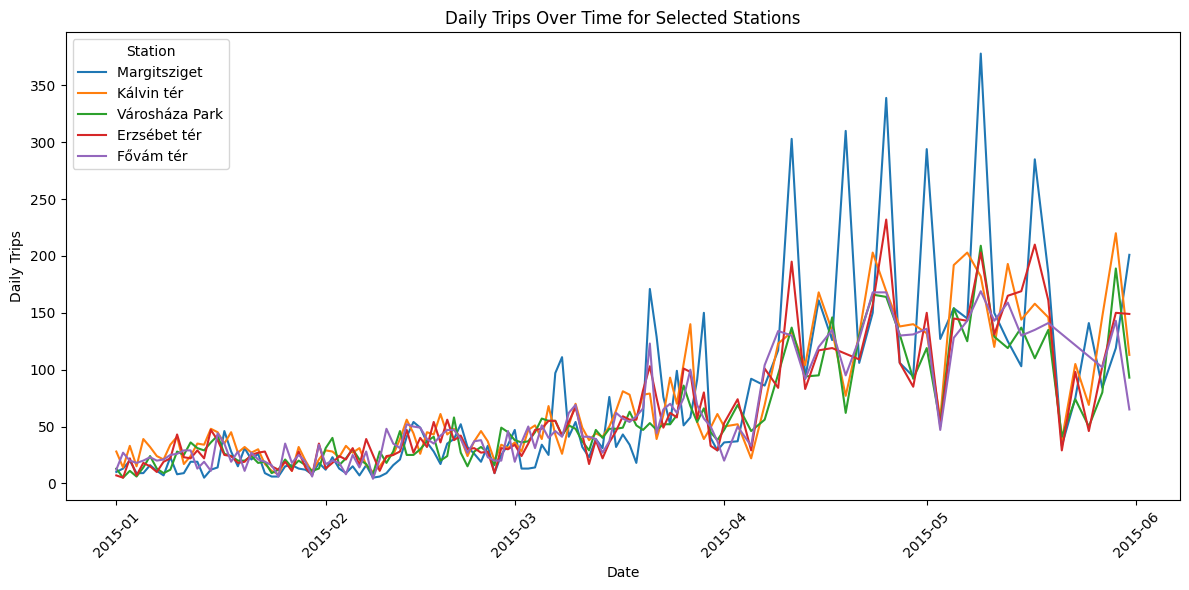

In [8]:
# List of selected station IDs.
selected_stations = [1304, 905, 517, 508, 515]

# Filter the aggregated daily_station DataFrame for these stations.
subset = daily_station[daily_station['station'].isin(selected_stations)].copy()

# Merge to get the station names (if desired).
subset = subset.merge(station_df[['place_id', 'place_name']], 
                        left_on='station', right_on='place_id', how='left')

# Convert 'date' column to datetime if it's not already.
subset['date'] = pd.to_datetime(subset['date'])

# Plot daily trips over time for each station.
plt.figure(figsize=(12, 6))

for station in selected_stations:
    df_station = subset[subset['station'] == station].sort_values('date')
    # Use the station name from the merged dataframe.
    station_name = df_station['place_name'].iloc[0] 
    plt.plot(df_station['date'], df_station['total_trips'], label=station_name)

plt.xlabel('Date')
plt.ylabel('Daily Trips')
plt.title('Daily Trips Over Time for Selected Stations')
plt.legend(title='Station')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Ensuring geographical spread
- ads should reach a diverse audience across the city.
- We could use geographical coordinated (lat and long) to check the distance between the top candidate to see if they are too close to be used together
- For the choice of threshold, in a compact urban area like Budapest, 1 km might be reasonable.

In [ ]:



# Create a Geo dataframe for the selected station IDs
selected_ids = [1304, 905, 517, 508, 515, 611]
geo_df = station_df[station_df['place_id'].isin(selected_ids)]

# Loop over all combinations of two different stations
for (i, row1), (j, row2) in itertools.combinations(geo_df.iterrows(), 2):
    # Extract coordinates as (latitude, longitude)
    coord1 = (row1['lat'], row1['lng'])
    coord2 = (row2['lat'], row2['lng'])
    
    # Compute the distance in kilometers
    distance = haversine(coord1, coord2, unit=Unit.KILOMETERS)
    
    # Check if distance is smaller than 1 km
    if distance < 1.0:
        print(f"Distance between station {row1['place_id']} and station {row2['place_id']}: {distance:.2f} km")


Distance between station 508 and station 517: 0.23 km
Distance between station 515 and station 905: 0.43 km
Distance between station 517 and station 905: 0.94 km


Distance between station 508 and station 517: 0.23 km, so We are going to choose station 517 at Városháza Park
Distance between station 515 and station 905: 0.43 km, we are going to choose station 905 Kálvin tér
Distance between station 517 and station 905: 0.94 km here also we choose Kálvin tér over the other as we already have 


# Three Station Final Choice:
After considering the most common and strategic places, We come to the conclusion that the best 3 stations to put ads are:
1.**Margaret Island Station** (1304): This station is located in Margaret Island, which is a 1 km2 Island in the middle of the Danube in central Budapest. The island is mostly covered by landscape parks, and is a popular recreational area. Also from previous analysis emerged that the most popular route was a "round trip" in Margaret Island, showing that it is clearly a recreational place and less of a commuting station. This way we are exposing the adds to a kind of public that is there for visiing and recreational activities, probably not in a rush so they can also be more receptive to the ads.

2. **Kálvin tér** (905): This station is located in a major square and intersection in the city center. It serves as a key urban hub where cultural events. Being a major thoroughfare and locality, the square is a major transport hub with tram, bus, and trolleybus routes serving the square. The Kálvin tér station on the M3 (North-South) line, and M4 of the Budapest Metro is located here. The Hungarian National Museum is also near Kálvin tér. This place is the second in average daily usage, and the first most common end station, meaning the majority of trips go there. It's trategic position combined with the different type of crowd make this place a great stratigic station to place ads

3. **Nyugati tér Station** (Station 611): Nyugati tér is the third most common end station, after Kálvin tér station. It is a major transportation hub in central Budapest, located near the WestEnd shopping mall and the Nyugati Railway Station. This area is bustling with commuters, tourists, and has strong public transport connections. In that way we are capturing a share of people that could be different from the Margaret Island one, as this is a central place, well connected to important public transport connection, with a high transit of people other then the bike service users.ù

